In [1]:
import os
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import cv2

In [2]:
# ließt Bild ein & konvertiert es zu Grauwertbild
def read_img(fn):
    img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
    #img = img/255
    return img

def motion_blur (img_shape, v):
    T = 1
    H = np.zeros(img_shape, dtype=np.complex128)
    for u1 in range(img_shape[0]):
        for u2 in range(img_shape[1]):     
            arg = u1*v[0] + u2*v[1]
            H[u1, u2] = T * np.sinc(arg) * np.exp(-1j*np.pi*arg)
    return H

def Inversefilter (G, H):
    F = G / H
    return ifft2(F) 

# Wienerfilter: mit Leistungsdichtespektren
def Wienerfilter1 (F, H, N):
    return (abs(H)**2) / (H * (abs(H)**2 + ((abs(N)**2)/(abs(F)**2))))
    #return (np.conj(H)) / ((np.abs(H)**2) + K)

# Wienerfilter: ohne Leistungsdichtespektren, Schätzung von K
def Wienerfilter2 (F, K):
    return (abs(H)**2) / (H * (abs(H)**2 + K))

# plottet alle Bilder
def plot(img_list):
    img_list = np.abs(img_list) 
    labels = ['F (Original)', 'G1 (Motion Blur)', 'G2 (Motion Blur + Rauschen)', 'I1 (Inverse ohne Rauschen)', 'I2 (Inverse mit Rauschen)', 
              'Wiener Filter (K ideal)', 'Wiener Filter (K geschätzt)']
    
    fig = plt.figure(figsize=(12, 12))
    for i in range(len(img_list)):
        fig.add_subplot(3, 3, i+1)
        plt.imshow(img_list[i], cmap = 'gray')
        plt.axis('off')
        plt.title(labels[i])
    plt.show()

## ##

## Bild einlesen ##

In [3]:
# Bild einlesen
img = read_img('Text1024.jpg')
#img = read_img('lena1960.jpg')
#img = cv2.resize(img, (1024, 1024))

# FFT des Bildes 
F = fft2(img)
#F = fftshift(F)

## H(u, v)  ##

In [4]:
# Bewegungsunschärfe-Funktion (v[0]: vertikal, v[1]: horizontal)
H = motion_blur(img.shape ,v=[0.0, 0.05])

# Gaussches Rauschen mit mu und sigma
noise = np.random.normal(0, 0.1, size=(img.shape[0],img.shape[1])) 
#noise = np.clip(noise, 0, 255)
N = fft2(noise)

# Bild mit Bewegungsunschärfe
G1 = F * H
G2 = F * H + N

img_blurred = ifft2(G1) 
img_blurred_noise = ifft2(G2) 

## Inversefilter ##

In [5]:
# inversefilter ohne rauschen
img_inverse1 = Inversefilter(G1, H)

# inversefilter mit rauschen
img_inverse2 = Inversefilter(G2, H)

## Wiener-Filter ##

In [6]:
W1 = Wienerfilter1(F, H, N)

K = 0.00001
W2 = Wienerfilter2(F, K)

img_wf1 = ifft2(G2 * W1)
img_wf2 = ifft2(G2 * W2)

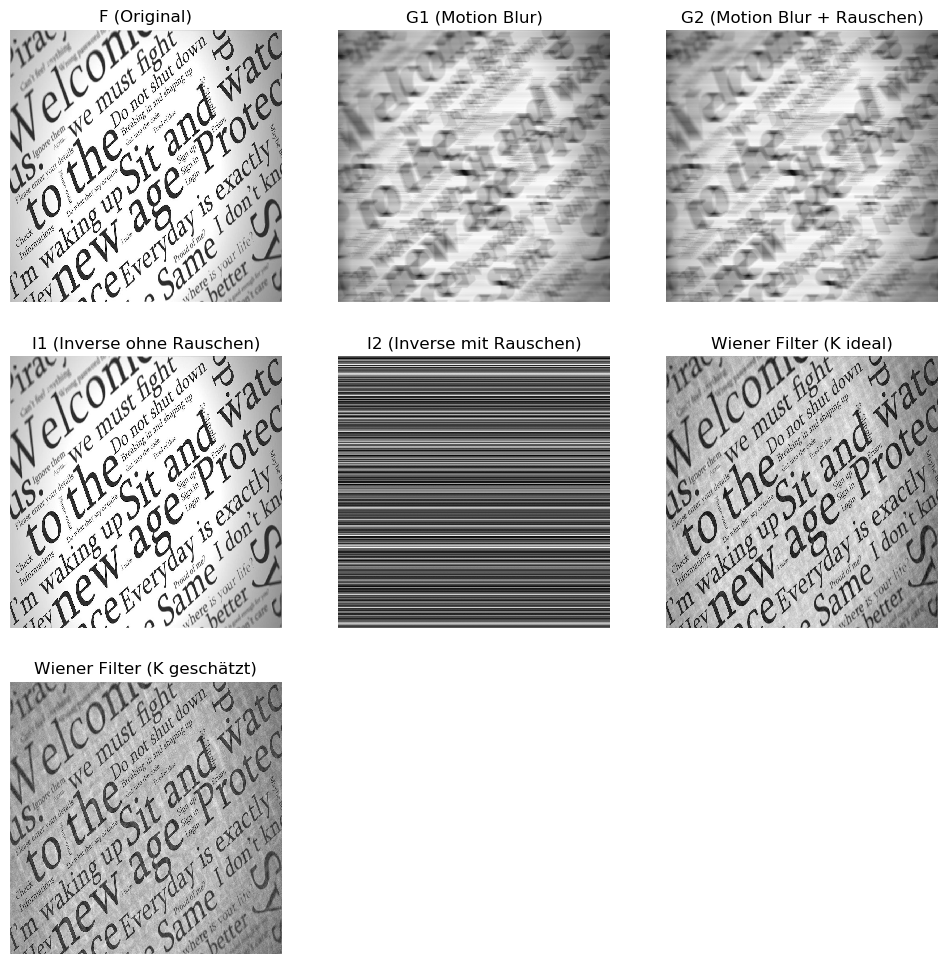

In [7]:
plot([img, img_blurred, img_blurred_noise, img_inverse1, img_inverse2, img_wf1, img_wf2])